# Import necessary libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [23]:
%reload_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import importlib

## Import our own modules

In [5]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [15]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search import naive_grid_search
from lib.ngs.uniform_discretization import uniform_discretization
from lib.ngs.utils_ngs import get_sup_error
from lib.ngs.loss_fn import reg_unif_weighted_logit

# Load data

In [7]:
# file path for Colab. May need to change this
X_df = pd.read_csv('X_processed.csv')
y_df = pd.read_csv('y_processed.csv')

In [8]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [9]:
train_X = torch.tensor(X, dtype=torch.float32)
train_y = torch.tensor(y, dtype=torch.float32)

In [10]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [11]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]

In [12]:
import time

In [13]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_legendre.csv')

# Display the DataFrame
truth

,losses,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,...,theta_36,theta_37,theta_38,theta_39,theta_40,theta_41,theta_42,theta_43,theta_44,theta_45
0,0.190793,-0.373029,0.186622,0.227443,-0.023583,0.164822,0.142992,0.168018,0.026305,0.142661,...,-0.018010,0.054908,-0.005629,0.000000,0.000000,-0.031270,-0.018010,-0.139608,-0.116840,-0.061673
1,0.192130,-0.371212,0.186634,0.227586,-0.023679,0.164875,0.142262,0.167428,0.025960,0.142993,...,-0.017600,0.054199,-0.005657,0.000069,0.000098,-0.031115,-0.017600,-0.139385,-0.116402,-0.061226
2,0.193463,-0.369401,0.186645,0.227729,-0.023775,0.164927,0.141535,0.166842,0.025615,0.143323,...,-0.017191,0.053493,-0.005685,0.000137,0.000195,-0.030961,-0.017191,-0.139162,-0.115965,-0.060781
3,0.194792,-0.367595,0.186656,0.227870,-0.023870,0.164977,0.140811,0.166258,0.025271,0.143653,...,-0.016784,0.052790,-0.005713,0.000205,0.000293,-0.030808,-0.016784,-0.138939,-0.115529,-0.060337
4,0.196117,-0.365794,0.186665,0.228009,-0.023964,0.165027,0.140089,0.165677,0.024927,0.143982,...,-0.016378,0.052089,-0.005741,0.000273,0.000390,-0.030655,-0.016378,-0.138717,-0.115094,-0.059894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.327684,0.692472,-0.029101,-0.033382,-0.017462,-0.005831,-0.225541,-0.146453,-0.051680,0.070009,...,0.105324,-0.201982,0.000913,0.013100,0.018598,0.063129,0.105324,0.157442,0.161747,0.171301
1020,0.325866,0.693930,-0.029932,-0.034521,-0.017548,-0.006565,-0.226194,-0.148351,-0.051246,0.068693,...,0.105340,-0.202186,0.000990,0.013040,0.018537,0.063366,0.105340,0.158131,0.162149,0.171464
1021,0.324032,0.695399,-0.030769,-0.035668,-0.017634,-0.007304,-0.226853,-0.150274,-0.050809,0.067366,...,0.105357,-0.202393,0.001066,0.012980,0.018475,0.063604,0.105357,0.158825,0.162554,0.171627
1022,0.322184,0.696878,-0.031613,-0.036822,-0.017720,-0.008050,-0.227517,-0.152223,-0.050369,0.066028,...,0.105374,-0.202601,0.001143,0.012919,0.018415,0.063843,0.105374,0.159523,0.162962,0.171792


In [14]:
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30', 'theta_31', 'theta_32', 'theta_33', 'theta_34',
                    'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39',
                    'theta_40', 'theta_41', 'theta_42', 'theta_43', 'theta_44',
                    'theta_45']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

# Loss function

In [16]:
loss_fn = reg_unif_weighted_logit

Use the previously tuned lr = 1.

In [17]:
lam_max = 1
lam_min = 0
lr = 1

## Assume access to a true loss oracle

In [18]:
max_epochs = 1000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(6, 18, 0.5)

In [30]:
total_pass_list = []
sup_error_list = []
reg_params = intercepts = weights = None
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))

    start_time = time.time()
    total_pass, reg_params, intercepts, weights, grid_pass_error = uniform_discretization(lam_min=lam_min, lam_max=lam_max,
                                                                    num_grid=num_grid, epochs=max_epochs, loss_fn=loss_fn,
                                                                    trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                                                    lr=lr, weighted_avg=False, testDataLoader=test_data_loader, 
                                                                    oracle=True,
                                                                    true_loss_list=true_losses, coarse_params=reg_params, 
                                                                    coarse_intercepts=intercepts, coarse_weights=weights, 
                                                                    stopping_criterion=delta, check_frequency=1, device=device)

    end_time = time.time()
    execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    sup_error = get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total passes #: {total_pass}\t sup error: {sup_error}\t grid error: {grid_pass_error}")

total_itr_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)

grid #: 8	 total passes #: 11	 sup error: 0.023149043321609497	 grid error: 0.010762333869934082
grid #: 10	 total passes #: 11	 sup error: 0.01917821168899536	 grid error: 0.007528424263000488
grid #: 11	 total passes #: 13	 sup error: 0.014810055494308527	 grid error: 0.006074726581573486
grid #: 13	 total passes #: 14	 sup error: 0.012060284614562988	 grid error: 0.005375981330871582
grid #: 16	 total passes #: 16	 sup error: 0.007740497589111328	 grid error: 0.0034458041191101074
grid #: 19	 total passes #: 22	 sup error: 0.005504786968231201	 grid error: 0.0024535655975341797
grid #: 23	 total passes #: 29	 sup error: 0.003651440143585205	 grid error: 0.0015311837196350098
grid #: 27	 total passes #: 31	 sup error: 0.0027672648429870605	 grid error: 0.0012557506561279297
grid #: 32	 total passes #: 34	 sup error: 0.0020253062248230536	 grid error: 0.0009643435478210449
grid #: 38	 total passes #: 48	 sup error: 0.0016486048698425293	 grid error: 0.0006117820739746094
grid #: 45	 t

In [33]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_legendre_oracle.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_legendre_oracle.csv')

C:\Users\dongq\AppData\Local\Temp\ipykernel_20472\3601952887.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


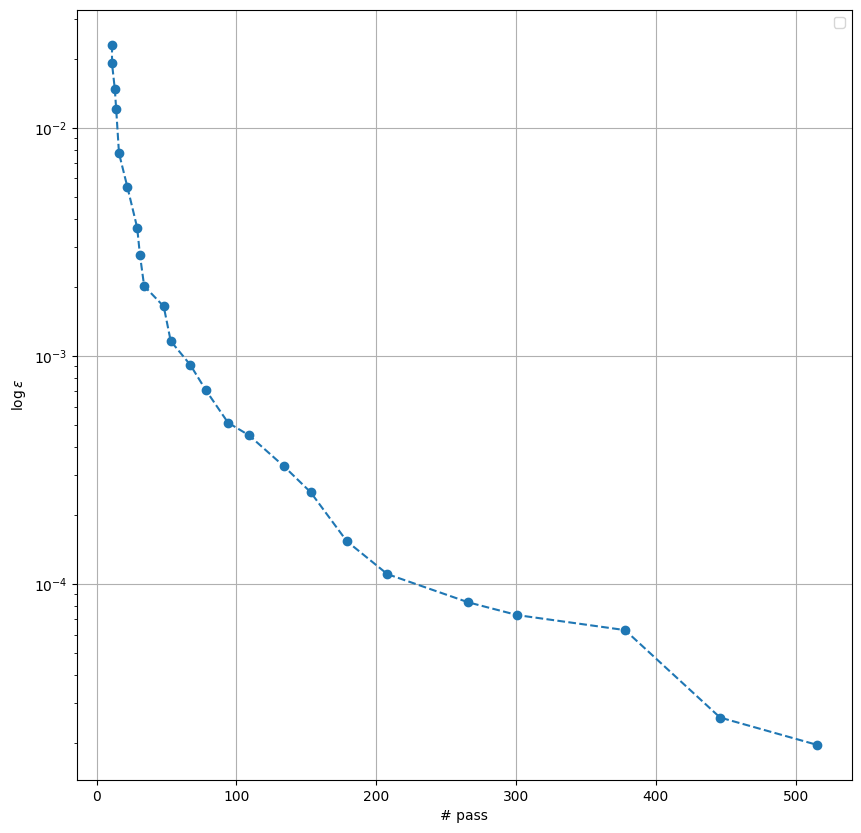

In [31]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_pass_list, (sup_error_list), '--o')
plt.yscale('log')
plt.xlabel('# pass')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Assume no access to true loss

In [ ]:
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(6, 18, 0.5)

In [30]:
total_pass_list = []
sup_error_list = []
grid_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))
    epochs = round(np.log(0.5/delta))

    # start_time = time.time()
    total_pass, reg_params, intercepts, weights, grid_pass_error = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader,
                                oracle=False, true_loss_list=true_losses,
                                check_frequency=1, device=device)

    # end_time = time.time()
    # execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    # solution path error
    sup_error = get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)
    grid_error_list.append(grid_pass_error)
    # print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")
    print(f"grid #: {num_grid}\t total iteration #: {total_pass}\t sup error: {sup_error}\t grid error: {grid_pass_error}")

total_pass_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)
grid_error_list = np.array(grid_error_list)

grid #: 8	 total iteration #: 24	 sup error: 0.04880702495574957	 grid error: 0.021548405289649963
grid #: 10	 total iteration #: 40	 sup error: 0.019930779933929443	 grid error: 0.008066833019256592
grid #: 11	 total iteration #: 44	 sup error: 0.017006635665893555	 grid error: 0.007521867752075195
grid #: 13	 total iteration #: 65	 sup error: 0.011225312948226929	 grid error: 0.0015870332717895508
grid #: 16	 total iteration #: 80	 sup error: 0.007516980171203613	 grid error: 0.0015870332717895508
grid #: 19	 total iteration #: 95	 sup error: 0.005176275968551691	 grid error: 0.0015870332717895508
grid #: 23	 total iteration #: 138	 sup error: 0.004353463649749756	 grid error: 0.0021057724952697754
grid #: 27	 total iteration #: 162	 sup error: 0.003331899642944336	 grid error: 0.0016693472862243652
grid #: 32	 total iteration #: 192	 sup error: 0.002621889114379883	 grid error: 0.001382291316986084
grid #: 38	 total iteration #: 266	 sup error: 0.0012104809284210205	 grid error: 0.0

In [ ]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list, grid_error_list, delta_list)), columns=['num_itr', 'sup_err', 'grid_err', 'delta'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_legendre.csv', index=False)

In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_legendre.csv')

In [6]:
sup_error_list = df['sup_err']
grid_error_list = df['grid_err']
delta_list = df['delta']
total_pass_list = df['num_itr']

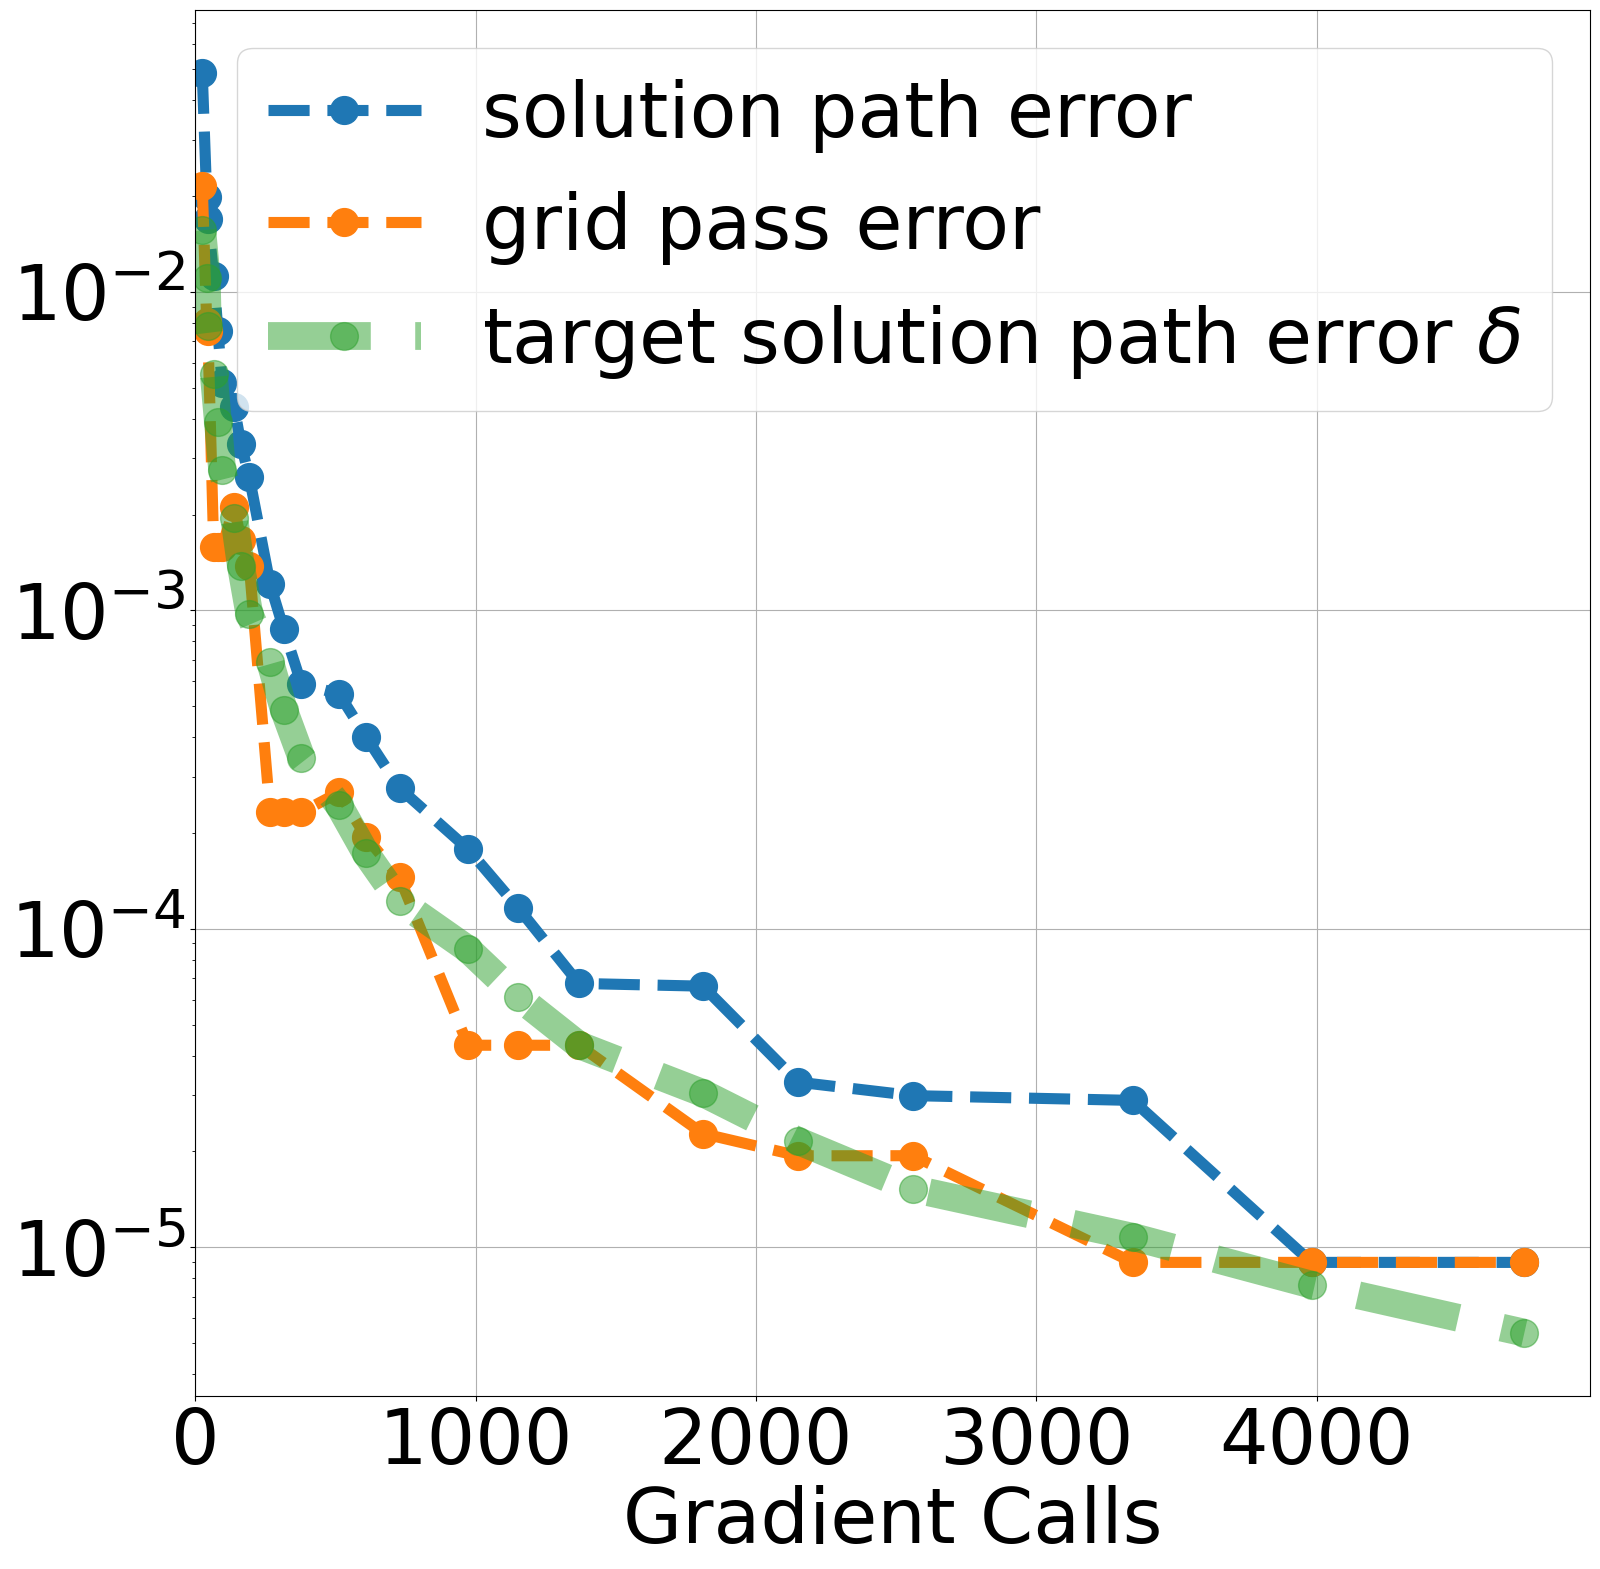

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(total_pass_list, (sup_error_list), '--o', linewidth=8, markersize=20, label="solution path error")
plt.plot(total_pass_list, (grid_error_list), '--o', linewidth=8, markersize=20, label="grid pass error")
plt.plot(total_pass_list, (delta_list), '--o', linewidth=18, markersize=20, label="target solution path error $\\delta$", alpha=0.5)

# Set global font size
mpl.rcParams['font.size'] = 55

# Tick labels
plt.yscale('log')

plt.xlim(0, )

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('Gradient Calls', fontsize=font_size)
# plt.ylabel('Presented in $\\log_{10}$', fontsize=font_size)
plt.legend()
plt.grid(True)
plt.savefig("NGS_stopping_criterion_exact.png")